# StochasticTITAN_2008

- **Paper**: A stochastic method for convective storm identification, tracking and nowcasting

- $\textbf{\textcolor{red}{Identification}}$:
    + **Identification**: the same as ETITAN_2007
    + **Sampling**: 
        + for each prev storm, uniformly drawing a set of particles inside storm.
        + num of particles = area of storm
        + assign equal weights for each particle

- $\textbf{\textcolor{blue}{Tracking}}$:
    + **Moton estimation**: Estimate the motion vector-field for each particle using TREC

    + **Matching**: 
        - $\textcolor{green}{\text{Partilce filtering}}$:
            + *Prediction*: make a forecast on each particle.
            + *Measurement*: for each assignment, count num or particles fall into the target

        - $\textcolor{green}{\text{Matching score (i,j)}}$:
            + $\operatorname{score}(i,j) = \operatorname{max}(NF_{i,j} / A_i; NF_{i,j} / A_j)$ 
            
            where $NF_{i,j}$ is the number of particles in storm $i$ predicted inside storm $j$ (later time)
            + if score > threshold => correct assignment

        - $\textcolor{green}{\text{Splitting \& Merging}}$: auto-handled by this approach.

        - $\textcolor{green}{\text{Deferred logic}}$: handle missing detection:
            + unmatched storm, still keep its particles

            + predict and update weights: $w_p = I_p / T_{min}$, where $T_{min}=35 dBz$ then normalized them (sum to 1)

            + compute the virtual centroid at that time

            + resample so that weights equal

            + use this virtual to predict the next frame. if matched => keep this state, otherwise, discard

- $\textbf{\textcolor{yellow}{Nowcasting}}$:
    + use TREC estimated vector motion on the centroid only to forecast.
    + fit linear interpolation model with exp smoothing.


In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

## Prepare dataset

In [2]:
# from src.preprocessing import read_image, windy_preprocessing_pipeline
# from tqdm import tqdm

# data_name = "philippines_13.269_123.832"
# SOURCE_PATH = f"data/image_old/{data_name}"

# img_paths = [
#     os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
# ][:50]

# img_shape = read_image(img_paths[0]).shape       # get shape of the image
# print(f"Image shape: {img_shape}")
# print(f"-" * 20)

# dbz_maps = []

# for path in tqdm(img_paths, desc="Processing images and detecting storms"):
#     img = read_image(path)
#     dbz_maps.append(windy_preprocessing_pipeline(img))

# print(f"Number of frames: {len(dbz_maps)}")

In [3]:
from src.preprocessing import read_numpy_grid, nexrad_numpy_preprocessing_pipeline
from tqdm.notebook import tqdm

data_name = "KGRR"

SOURCE_PATH = f"data/numpy_grid/{data_name}"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.npy')
]

# img_shape = read_numpy_grid(img_paths[0]).shape       # get shape of the image
print(f"-" * 20)

dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    img = read_numpy_grid(path)
    dbz_map = nexrad_numpy_preprocessing_pipeline(img)
    dbz_maps.append(np.nan_to_num(dbz_map))

dbz_map_sample = dbz_maps[0]
img_shape = (dbz_map_sample.shape[0], dbz_map_sample.shape[1], 3)
print(f"Image shape: {img_shape}")

print(f"Number of frames: {len(dbz_maps)}")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

--------------------


Processing images and detecting storms:   0%|          | 0/31 [00:00<?, ?it/s]

Image shape: (901, 901, 3)
Number of frames: 31


## 1. Identification

In [4]:
from src.identification import MorphContourIdentifier, HypothesisIdentifier
from src.preprocessing import convert_contours_to_polygons, convert_polygons_to_contours
from src.cores.base import StormObject, StormsMap
from datetime import datetime
from shapely import Polygon
from sklearn.cluster import KMeans
from copy import deepcopy
from shapely.affinity import translate

THRESHOLD = 35
DISTANCE_DBZ = 5
FILTER_AREA = 20        # storm with area under this threshold => cancel
FILTER_CENTER = 10
DENSITY = 0.05           # number of particles of a storm = area * DENSITY

class ParticleStorm(StormObject):
    centroid: np.ndarray                            # The centroid of the storm, represented as a numpy array with 2 elements (y, x)
    particles: list[np.ndarray] = []                # List of particles, each particle is represented as a numpy array with 2 elements (y, x)
    estimated_movement: tuple[float, float] = None  # Estimated movement vector (dy, dx)
    particles_movements: tuple[list, list] = None   # List of movements for each particle
    is_virtual: bool                                # Flag to indicate if the storm is virtual (not detected in current frame)

    def __init__(self, polygon: Polygon, centroid: tuple[float, float], density: float, id: str=""):
        super().__init__(contour=polygon, id=id)
        contour = convert_polygons_to_contours([polygon])[0]
        self.particles = self._sample_particles(contour, density)
        self.centroid = np.array(centroid).astype(np.int64)
        self.is_virtual = False

    def _sample_particles(self, contour: np.ndarray, density: float, shape = img_shape) -> np.ndarray:
        """
        Sample a list of particles inside the contour.

        Args:
            contour (np.ndarray): the list of points, in order, creating the contour.
            div (float, default): determine the number of particles = area / div.
        
        Returns:
            particles (np.ndarray): the list of particles.
        """
        # get the set of points bounded by the contour
        mask = np.zeros(shape=shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [contour], color=1)
        points = np.argwhere(mask > 0)

        # uniformly sample points using k-means.
        num_particles = int(cv2.contourArea(contour) * density) + 1
        k_means = KMeans(n_clusters=num_particles)
        k_means.fit(points)

        # particles: list of (y, x)
        return k_means.cluster_centers_.astype(np.int64)

    def copy(self) -> "ParticleStorm":
        # Allocate new object without calling __init__
        new_obj = self.__class__.__new__(self.__class__)

        # Copy all attributes manually (deepcopy for safety)
        new_obj.__dict__ = deepcopy(self.__dict__)
        new_obj.id = "pred_" + new_obj.id

        return new_obj
    
    def make_move(self, displacement: np.ndarray):
        """
        Move the storm by the given displacement.
        """
        dy, dx = displacement
        self.contour = translate(self.contour, xoff=dx, yoff=dy)
        self.centroid = (self.centroid + displacement).astype(np.int64)
        self.particles = [particle + displacement for particle in self.particles]

    def get_num_particles(self):
        """
        Get the number of particles.
        """
        return len(self.particles)

    def update_particles_movement(self, **kargs):
        """
        Estimate the movements of the particles and the movement of the storm.
        """
        # retrieve parameters of estimatied-motion map.
        block_size = kargs.get("block_size", 64)
        vy = kargs.get("vy", np.array([]))
        vx = kargs.get("vx", np.array([]))

        if len(vy) == 0 or len(vx) == 0:
            raise ValueError("vy, vx must be provided.")

        # get the nearest index of each particle in the estimated-motion map.
        x_idx = np.round(self.particles[:, 1] / block_size).astype(np.int64)
        y_idx = np.round(self.particles[:, 0] / block_size).astype(np.int64)

        dy_list = vy[y_idx, x_idx]
        dx_list = vx[y_idx, x_idx]

        self.particles_movements = (dy_list, dx_list) # store the movements of each particle

    def update_storm_movement(self, **kargs):
        # retrieve parameters of estimatied-motion map.
        block_size = kargs.get("block_size", 64)
        vy = kargs.get("vy", np.array([]))
        vx = kargs.get("vx", np.array([]))

        if len(vy) == 0 or len(vx) == 0:
            raise ValueError("vy, vx must be provided.")

        # estimate the movement of the storm by the movement at the centroid.
        x_centroid_idx = int(np.round(self.centroid[1] / block_size))
        y_centroid_idx = int(np.round(self.centroid[0] / block_size))

        self.estimated_movement = (vy[y_centroid_idx, x_centroid_idx], vx[y_centroid_idx, x_centroid_idx])
    
    def retrieve_particles_movement(self):
        """
        Retrieve the movements of each particle.
        """
        # case no movement is estimated yet. e.g., first frame
        if self.particles_movements is None:
            return self.particles, [0]*len(self.particles), [0]*len(self.particles)
        dy_list, dx_list = self.particles_movements
        return self.particles, dy_list, dx_list

    def retrieve_storm_movement(self):
        """
        Retrieve the estimated movement of the storm.
        """
        return self.estimated_movement


    def count_particles_in_storm(self, particles: np.ndarray) -> int:
        """
        Count the number of particles inside the given contour.
        """
        mask = np.zeros(shape=img_shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, convert_polygons_to_contours([self.contour]), color=1)

        y_points = particles[:, 0]
        x_points = particles[:, 1]

        particle_mask = np.zeros(shape=img_shape[:2], dtype=np.uint8)
        particle_mask[y_points, x_points] = 1

        return np.sum(mask * particle_mask)

    def sample_new_particles(self, pred_particles: np.ndarray, dbz_map: np.ndarray, min_dbz: float):
        """
        Sample new particles to adapt the virtual storm based on the deferred logic.
        """
        x_points = pred_particles[:, 1]
        y_points = pred_particles[:, 0]

        weights = (dbz_map[y_points, x_points] / min_dbz)
        weights = np.clip(weights, a_min=1e-3, a_max=None)   # ensure
        norm_weights = weights / (np.sum(weights) + 1e-10)

        try:
            resampled_indices = np.random.choice(
                np.arange(len(pred_particles)),
                size=len(self.particles),
                replace=True,
            p=norm_weights
        )
        
        except ValueError:
            print(f"weights: {norm_weights}")
            raise ValueError("Sampling new particles failed due to invalid weights.")
        
        self.particles = pred_particles[resampled_indices]


class DbzStormsMap(StormsMap):
    storms: list[ParticleStorm]
    dbz_map: np.ndarray

    def __init__(self, storms: list[ParticleStorm], time_frame: datetime, dbz_map: np.ndarray):
        """
        Beside 2 default attributes, also keep track of `dbz_map` for computin correlation.
        """
        super().__init__(storms, time_frame)
        self.dbz_map = dbz_map

    def _retrieve_block_movement(self, block: np.ndarray, search_region: np.ndarray) -> np.ndarray:
        block = block.astype(np.float32)
        search_region = search_region.astype(np.float32)
        result = cv2.matchTemplate(search_region, block, cv2.TM_CCOEFF_NORMED)
        return np.unravel_index(np.argmax(result), result.shape)

    def trec_estimate(self, other_storms_map: "DbzStormsMap", is_previous: bool = False, **kargs) -> np.ndarray:
        """
        Generate a correlation map which show the movement between the this to the next storm map.
        """
        block_size = kargs.get("block_size", 64)
        stride = kargs.get("stride", block_size)
        local_buffer = kargs.get("buffer", 50)      # search region = block + expanded by local_buffer

        dbz_map_1 = self.dbz_map
        dbz_map_2 = other_storms_map.dbz_map
        H, W = dbz_map_2.shape

        ys = list(range(0, H-block_size+1, stride))     # ys: list[start_idx of H-axis]
        xs = list(range(0, W-block_size+1, stride))     # xs: list[start_idx of W-axis]

        vy = np.zeros(shape=(len(ys), len(xs)))         # vy: keep the y-value of movement at corresponding position
        vx = np.zeros_like(vy)                          # vx: keep the y-value of movement at corresponding position

        for i, y in enumerate(ys):
            for j, x in enumerate(xs):
                block = dbz_map_1[y:y+block_size, x:x+block_size]
                if np.std(block) < 1e-3:    # case std is too small => continue
                    continue

                # otherwise: get the search region
                y_search_low, y_search_high = max(0,y-local_buffer), min(H,y + block_size + local_buffer)   # ensure the seach region is not overflow.
                x_search_low, x_search_high = max(0,x-local_buffer), min(W,x + block_size + local_buffer)

                search_region = dbz_map_2[y_search_low:y_search_high, x_search_low:x_search_high]
                dy, dx = self._retrieve_block_movement(block, search_region)

                y_center, x_center = y_search_low + dy + block_size / 2, x_search_low + dx + block_size / 2
                y_block_center = y + block_size / 2
                x_block_center = x + block_size / 2

                # displacement from dbz_map_1 -> dbz_map_2 = center - original position
                vy[i][j] = y_center - y_block_center
                vx[i][j] = x_center - x_block_center

        if is_previous: # case other storm map is previous frame => invert the movement
            vy = -vy
            vx = -vx
            for storm in self.storms:
                storm.update_storm_movement(block_size=block_size, vy=vy, vx=vx)
        
        else:           # case other storm map is next frame
            # update particles movement for each storm.
            for storm in self.storms:
                storm.update_particles_movement(block_size=block_size, vy=vy, vx=vx)

    def create_virtual_storm(self, storm: ParticleStorm, pred_particles: np.ndarray, min_dbz: float=35) -> ParticleStorm:
        """
        Create a virtual storm based on the given storm.
        """
        new_storm = storm.copy()
        new_storm.sample_new_particles(pred_particles, self.dbz_map, min_dbz=min_dbz)

        new_storm.id = "_".join(self.storms[0].id.split("_")[:-1] + [str(len(self.storms)), "virtual"])
        new_storm.is_virtual = True
        self.storms.append(new_storm)

Processing images and detecting storms:   0%|          | 0/31 [00:00<?, ?it/s]

--------------------
Time: 2024-05-07 22:04:53 | Detected storms: 57
Time: 2024-05-07 22:11:01 | Detected storms: 66
Time: 2024-05-07 22:17:10 | Detected storms: 58
Time: 2024-05-07 22:23:19 | Detected storms: 86
Time: 2024-05-07 22:29:38 | Detected storms: 74
Time: 2024-05-07 22:35:56 | Detected storms: 75
Time: 2024-05-07 22:42:40 | Detected storms: 67
Time: 2024-05-07 22:49:09 | Detected storms: 70
Time: 2024-05-07 22:55:28 | Detected storms: 79
Time: 2024-05-07 23:01:36 | Detected storms: 80
Time: 2024-05-07 23:07:46 | Detected storms: 66
Time: 2024-05-07 23:13:52 | Detected storms: 61
Time: 2024-05-07 23:19:35 | Detected storms: 65
Time: 2024-05-07 23:25:16 | Detected storms: 62
Time: 2024-05-07 23:30:46 | Detected storms: 65
Time: 2024-05-07 23:36:51 | Detected storms: 75
Time: 2024-05-07 23:43:08 | Detected storms: 64
Time: 2024-05-07 23:49:50 | Detected storms: 63
Time: 2024-05-07 23:56:33 | Detected storms: 55
Time: 2024-05-08 00:03:03 | Detected storms: 55
Time: 2024-05-08 00

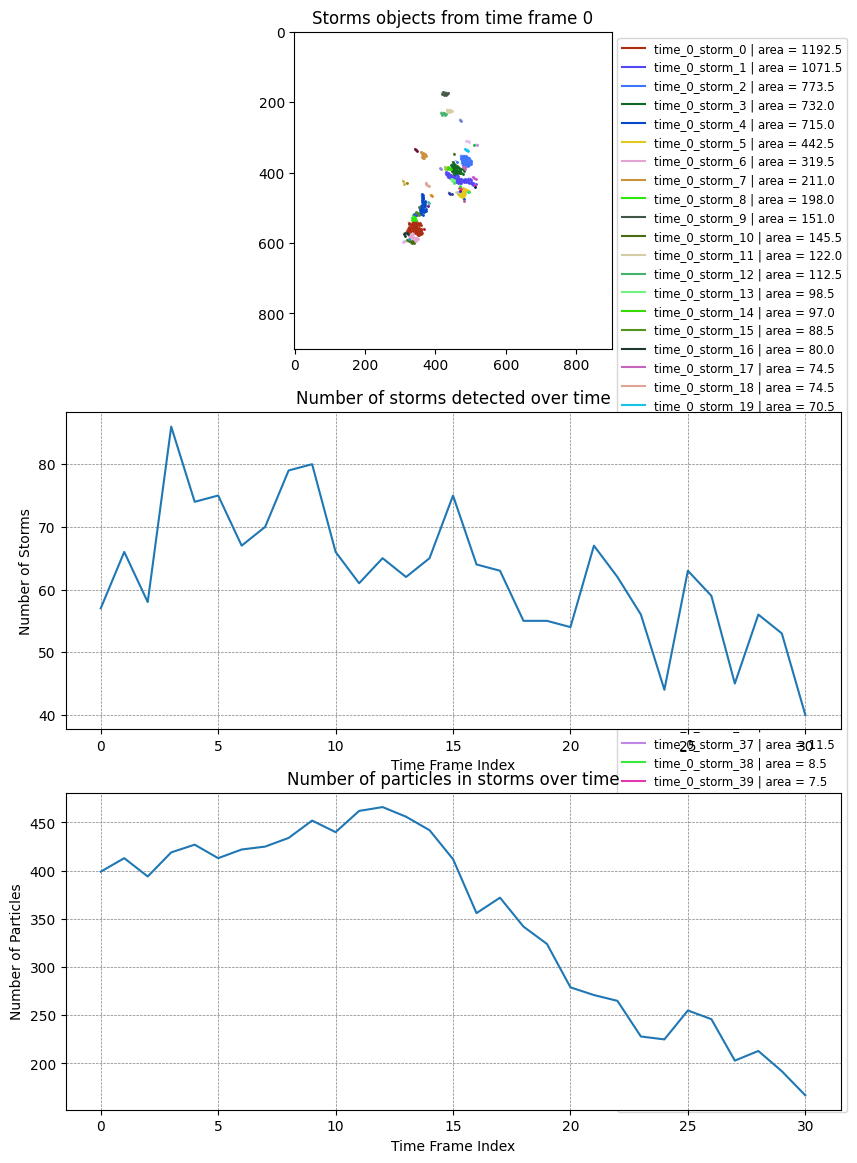

In [5]:
# identifier = MorphContourIdentifier()
identifier = HypothesisIdentifier(distance_dbz_threshold=DISTANCE_DBZ, filter_center=FILTER_CENTER)
storms_map_time_lst: list[DbzStormsMap] = []

for time_idx, (path, dbz_map) in tqdm(enumerate(zip(img_paths, dbz_maps)), total=len(img_paths), desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]

    # Convert contours to polygons
    contours = identifier.identify_storm(dbz_map, threshold=THRESHOLD, filter_area=FILTER_AREA)
    polygons = convert_contours_to_polygons(contours)
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)

    # Construct storms map
    try:
        time_frame = datetime.strptime(file_name[4:19], "%Y%m%d_%H%M%S")
    except:
        time_frame = datetime.strptime(file_name, "%Y%m%d-%H%M%S")

    # Keep list of storms
    storms = []

    for idx, polygon in enumerate(polygons):
        contour = convert_polygons_to_contours([polygon])[0]

        # Create the mask of current storm
        mask = np.zeros_like(dbz_map, dtype=np.uint8)
        cv2.fillPoly(mask, contour, color=1)

        # Extract DBZ values inside mask
        weights = dbz_map * mask

        # Create coordinate grids
        y_idx, x_idx = np.indices(dbz_map.shape)

        # Compute weighted centroid
        total_weight = weights.sum()
        if total_weight == 0:
            centroid = (np.nan, np.nan)  # or fallback
        else:
            cx = (x_idx * weights).sum() / total_weight
            cy = (y_idx * weights).sum() / total_weight
            centroid = (int(cy), int(cx))

        storms.append(ParticleStorm(
                polygon, centroid=centroid, id=f"time_{time_idx}_storm_{idx}", density=DENSITY
            ))
        
    storms_map = DbzStormsMap(storms, time_frame=time_frame, dbz_map=dbz_map)
    storms_map_time_lst.append(storms_map)

print("-"*20)

# print number of detected storms over time
for storms_map in storms_map_time_lst:
    print(f"Time: {storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | Detected storms: {len(storms_map.storms)}")

print("-"*20)
# print number of detected storms over time
plt.figure(figsize=(10, 14))

plt.subplot(3,1,1)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

for storm in storms_map_time_lst[0].storms:
    color = np.random.randint(0, 255, size=3).tolist()
    y_centroid, x_centroid = storm.centroid
    particles = storm.particles
    x_points, y_points = particles[:, 1], particles[:, 0]
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f}")
    plt.scatter(x_points, y_points, color=np.array(color)/255.0, s=1)
    # plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=1)

plt.legend(loc="upper left", fontsize='small', ncol=1, bbox_to_anchor=(1, 1))
plt.imshow(blank_image,cmap="gray")
plt.title('Storms objects from time frame 0')
plt.tight_layout()


plt.subplot(3,1,2)
number_of_storms = [len(storms_map.storms) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of storms detected over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Storms')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.tight_layout()

plt.subplot(3,1,3)
number_of_particles = [np.sum([storm.get_num_particles() for storm in storms_map.storms]) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_particles)), number_of_particles)
plt.title('Number of particles in storms over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Particles')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.tight_layout()
plt.show()

### Visualize a TREC estimation

Prev storm centroid: (x=341, y=559)
--------------------------------------------------


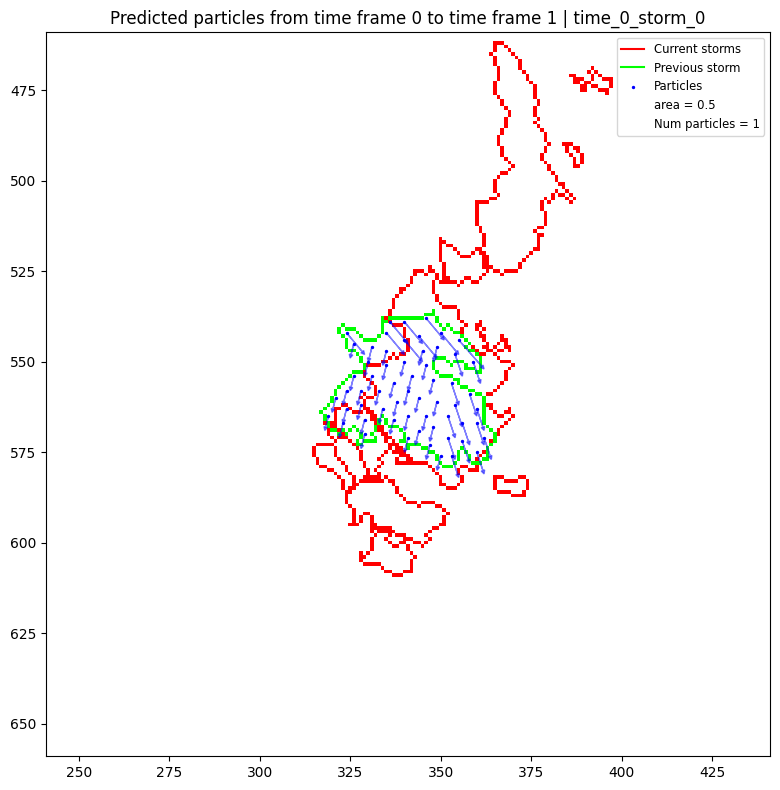

In [6]:
storms_map_1 = storms_map_time_lst[0]
storms_map_2 = storms_map_time_lst[1]

storms_map_1.trec_estimate(storms_map_2)

storm_idx = 0
prev_storm = storms_map_1.storms[storm_idx]

centroid_y, centroid_x = prev_storm.centroid
print(f"Prev storm centroid: (x={centroid_x}, y={centroid_y})")
print(f"-" * 50)

######## plot figure ########
plt.figure(figsize=(8, 8))
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

# plot current storm contours
for storm in storms_map_2.storms:
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, (255,0,0), thickness=1)
plt.plot([], [], color=(1,0,0), label=f"Current storms")

# plot previous storm contour
cv2.drawContours(blank_image, convert_polygons_to_contours([prev_storm.contour]), -1, (0,255,0), thickness=1)
plt.plot([], [], color=(0,1.0,0), label=f"Previous storm")

particles, dy_list, dx_list = prev_storm.retrieve_particles_movement()

x_points, y_points = particles[:, 1], particles[:, 0]
plt.scatter(x_points, y_points, color=(0,0,1), s=2, label=f"Particles")


# plot movement of each particle
for particle, dy, dx in zip(particles, dy_list, dx_list):
    y, x = particle
    plt.arrow(x, y, dx, dy, color=(0,0,1), head_width=1, head_length=1, length_includes_head=True, alpha=0.5)

plt.plot([], [], color=(1,1,1), label=f"area = {storm.contour.area:.1f}")
plt.plot([], [], color=(1,1,1), label=f"Num particles = {storm.get_num_particles()}")
plt.legend(loc="upper right", fontsize='small', ncol=1, bbox_to_anchor=(1, 1))

plt.imshow(blank_image)
plt.title(f'Predicted particles from time frame 0 to time frame 1 | {prev_storm.id}')
plt.tight_layout()

plt.xlim(centroid_x-100, centroid_x+100)
plt.ylim(centroid_y+100, centroid_y-100)
plt.show()

Curr storm centroid: (x=351, y=552)


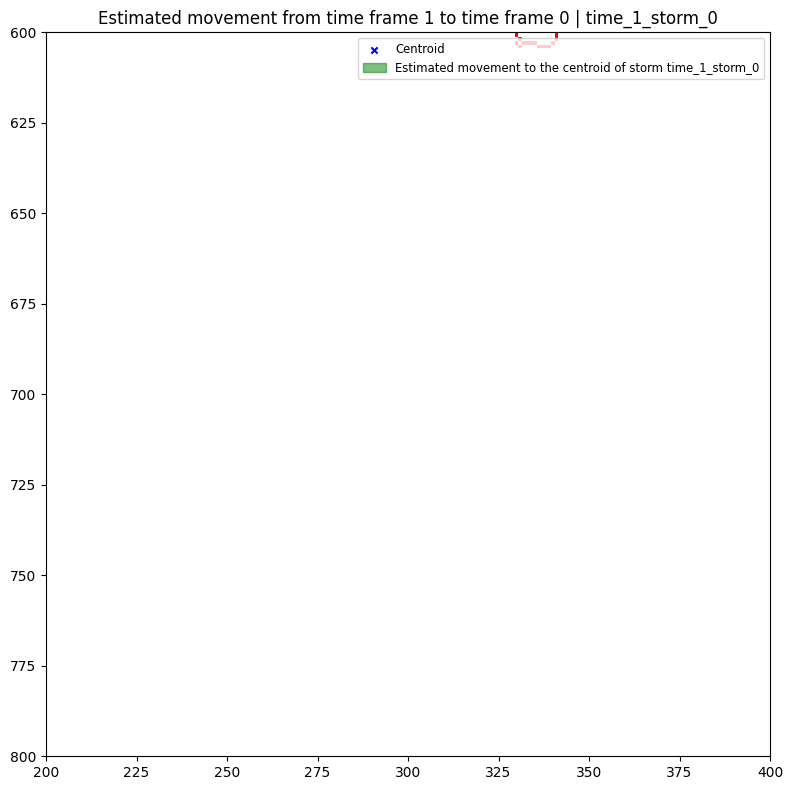

In [7]:
storms_map_1 = storms_map_time_lst[0]
storms_map_2 = storms_map_time_lst[1]

storms_map_2.trec_estimate(storms_map_1, is_previous=True)

storm_idx = 0

blank_image = np.ones(img_shape, dtype=np.uint8) * 255
curr_storm = storms_map_2.storms[storm_idx]

centroid_y, centroid_x = curr_storm.centroid

plt.figure(figsize=(8, 8))
cv2.drawContours(blank_image, convert_polygons_to_contours([curr_storm.contour]), -1, (0,255,0), thickness=1)
print(f"Curr storm centroid: (x={centroid_x}, y={centroid_y})")


plt.scatter(centroid_x, centroid_y, color=(0,0,1.0), s=20, marker='x', label=f"Centroid")
dy, dx = curr_storm.estimated_movement
plt.arrow(centroid_x-dx, centroid_y-dy, dx, dy, color=(0,0.5,0), head_width=2, head_length=2, length_includes_head=True, alpha=0.5, label=f"Estimated movement to the centroid of storm {curr_storm.id}")

prev_contours = convert_polygons_to_contours([storm.contour for storm in storms_map_1.storms])
cv2.drawContours(blank_image, prev_contours, -1, (255,0,0), thickness=1)

plt.imshow(blank_image)
plt.title(f'Estimated movement from time frame 1 to time frame 0 | {curr_storm.id}')
plt.tight_layout()
plt.legend(loc="upper right", fontsize='small', ncol=1)

plt.xlim(200,400)
plt.ylim(800,600)
plt.show()

## 2. Tracking

### 2.1 Implementation of `Matcher`

- **Idea**:

    + Make a forecast for each particle using TREC.
    
    + Check where each fall into for each particle.

    + Matching pair => storms with high overlapping (number of predicted particles fall into the new position)

In [8]:
from src.tracking import BaseMatcher, BaseTrackingHistory, BaseTracker

class Matcher(BaseMatcher):
    max_velocity: float     # unit: pixel/hr

    def __init__(self, max_velocity: float):
        self.max_velocity = max_velocity
    
    def _construct_disparity_matrix(self, object_lst1, object_lst2):
        # not use disparity matrix here
        pass

    def match_storms(
            self, prev_storms_map: DbzStormsMap, curr_storms_map: DbzStormsMap, matching_overlap_threshold: float = 0.5
        ) -> np.ndarray:
        """
        Match storms between 2 time frame.

        Args:
            storm_map_1 (StormsMap): storm map in the 1st frame.
            storm_map_2 (StormsMap): storm map in the 2nd frame.
        
        Returns:
            assignments (np.ndarray): Array of (prev_idx, curr_idx) pairs representing matched storms.
            pred_particles_lst (list[np.ndarray]): List of predicted particles for each storm in storm_map_1.
        """
        dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600.0    # in hours
        buffer = int(self.max_velocity * dt)    # in pixels
        
        NF_matrix = np.zeros((len(prev_storms_map.storms), len(curr_storms_map.storms)), dtype=np.float64)
        for i, prev_storm in enumerate(prev_storms_map.storms):
            particles, dy_list, dx_list = prev_storm.retrieve_particles_movement()
            pred_particles = np.array([particle + np.array([dy, dx]) for particle, dy, dx in zip(particles, dy_list, dx_list)], dtype=np.int64)

            for j, curr_storm in enumerate(curr_storms_map.storms):
                NF_matrix[i][j] = curr_storm.count_particles_in_storm(pred_particles) / min([curr_storm.get_num_particles(), prev_storm.get_num_particles()])
        
        return np.argwhere(NF_matrix >= matching_overlap_threshold)

In [9]:
BLOCK_SIZE = 64
OVERLAP_THRESHOLD = 0.45
MAX_VELOCITY = 50              # pixel/hr

prev_storms_map = storms_map_time_lst[1]
curr_storms_map = storms_map_time_lst[2]

prev_storms_map.trec_estimate(curr_storms_map, block_size=BLOCK_SIZE)

curr_storms_map.storms = [storm for storm in curr_storms_map.storms if storm.is_virtual == False]

matcher = Matcher(MAX_VELOCITY)
assignments = matcher.match_storms(prev_storms_map, curr_storms_map, matching_overlap_threshold=OVERLAP_THRESHOLD)

assignments

array([[ 0,  0],
       [ 1,  1],
       [ 1, 18],
       [ 2,  3],
       [ 2,  8],
       [ 3,  9],
       [ 3, 14],
       [ 3, 29],
       [ 3, 43],
       [ 4,  2],
       [ 5, 11],
       [ 5, 12],
       [ 5, 16],
       [ 5, 34],
       [ 6, 23],
       [ 7,  4],
       [ 8,  6],
       [ 9,  7],
       [10,  4],
       [11,  5],
       [12, 13],
       [13, 17],
       [14,  4],
       [15, 15],
       [16,  5],
       [17,  2],
       [18, 20],
       [19, 32],
       [20, 24],
       [21, 27],
       [22, 19],
       [23, 25],
       [24,  4],
       [25, 10],
       [26, 18],
       [27, 44],
       [28, 36],
       [29, 33],
       [30, 21],
       [31, 26],
       [32, 35],
       [33, 38],
       [34, 11],
       [35, 30],
       [36, 10],
       [41, 42],
       [47,  0],
       [51, 23],
       [54,  0],
       [57, 17],
       [59,  2],
       [63, 10]])

### 2.2 Implementation of `TrackingHistory`

- **Idea**: keep track of storms evolution over time.

- **Deferred logic**: handle missing detection:

    + unmatched storm, still keep its particles

    + predict and update weights: $w_p = I_p / T_min$, then normalized them (sum to 1)

    + compute the virtual centroid at that time

    + resample so that weights equal
    
    + use this virtual to predict the next frame. if matched => keep this state, otherwise, discard

- **Public methods**:
    - $\textcolor{yellow}{\text{forecast}}$: forecast the next position of current storm track.
    - $\textcolor{yellow}{\text{update}}$: receive the mapping of current storms and update the track.

In [10]:
from dataclasses import dataclass, field
from copy import deepcopy

@dataclass
class StormRecord:
    """
    Record: is a part of `StormTrack`, contains information about a storm at a specific time frame.
    """
    track_id: int
    storm: ParticleStorm
    time_frame: datetime
    is_splitted: bool = field(default=False)      # if splitted: the current storm of the corresponding track is splitted and this storm is created to keep track of the splitted part.
    parent_track_id: int = field(default=None)   # if virtual: the id of the parent track from which this storm is splitted.

@dataclass
class StormTrack:
    """
    Track: contains the history of a storm over time frames.
    """
    id: int
    records: list[StormRecord] = field(default_factory=list)
    movements: list[np.ndarray] = field(default_factory=list)   # list of movement vectors over time
    active: bool = field(default=True)                          # whether the track is still active or not
    merged: bool = field(default=False)                         # in case the track is inactive, check whether the track has been merged into another track
    merged_to: int = field(default=None)                        # if merged, the id of the track to which this track is merged

    def add_record(self, record: StormRecord, motion_vector: np.ndarray = None):
        self.records.append(record)
        if motion_vector is not None:
            self.movements.append(motion_vector)
    
    def get_latest_record(self) -> StormRecord:
        return self.records[-1] if self.records else None
    
    def get_copy(self, new_id: int, last_time: datetime) -> "StormTrack":
        """
        Return a copy of the current track with a new id.
        """
        new_track = StormTrack(id=new_id)
        new_track.records = deepcopy(self.records)
        for record in new_track.records:
            record.track_id = new_id
            record.is_splitted = True
            record.parent_track_id = self.id

        for movement in self.movements:
            new_track.movements.append(deepcopy(movement))

        if len(new_track.records) > 0 and new_track.records[-1].time_frame >= last_time:
            # drop the last record if it exceeds the last time
            new_track.records.pop()
            if len(new_track.movements) > 0:
                new_track.movements.pop()

        return new_track
    
    def pop_last_record(self):
        """
        Pop the last record and movement from the track. Typical case: unmatched virtual storm.
        """
        if len(self.records) > 0:
            self.records.pop()
        if len(self.movements) > 0:
            self.movements.pop()

In [11]:
from copy import deepcopy
from shapely import Polygon
from shapely.affinity import translate
from enum import Enum

from warnings import warn

class TrackStatus(Enum):
    ACTIVE = 0
    VIRTUAL = 1     # case the storm is missing in current frame, but we still keep it for some frames to see if it re-appears
    EXPIRED = 2

    def print_status(self):
        if self == TrackStatus.ACTIVE:
            return "Active"
        elif self == TrackStatus.VIRTUAL:
            return "Virtual"
        elif self == TrackStatus.EXPIRED:
            return "Expired"

class TrackingHistory(BaseTrackingHistory):
    virtual_list: list[int] = []   # list of track idx which are currently virtual
    tracks: list[StormTrack] = []  # list of all tracks

    def __init__(self, storms_map: StormsMap):
        self.tracks = []
        for storm in storms_map.storms:
            self.tracks.append(self._initialize_track(storm, storms_map.time_frame))

        self.storm_dict = {storm.id: idx for idx, storm in enumerate(storms_map.storms)}
        self.active_list = list(range(len(self.storm_dict)))
        self.virtual_list = []
    
    def _initialize_track(self, storm: ParticleStorm, time_frame: datetime):
        new_id = len(self.tracks)
        return StormTrack(
            id=new_id,
            records=[StormRecord(
                track_id=new_id,
                storm=storm,
                time_frame=time_frame
            )]
        )
    
    def _get_track(self, storm_id: str) -> StormTrack:
        """
        Get the track of storm with storm_id, if there is no track found, raise `KeyError`.

        Args:
            storm_id (str): id of the storm
        
        Returns:
            track (StormTrack)
        """
        if storm_id not in self.storm_dict:
            raise KeyError(f"Storm not found in the current track.")
        track_id = self.storm_dict[storm_id]
        return self.tracks[track_id]

    def _interpolate_velocity(self, velocity_lst: list[np.ndarray], alpha_decay: float = 0.5) -> np.ndarray:
        """
        Interpolate the velocity using weighted average with decay factor alpha_decay.

        Args:
            velocity_lst (list[np.ndarray]): list of velocity vectors.
            alpha_decay (float, default=0.5): the decay factor.

        Returns:
            interpolated_velocity (np.ndarray): the interpolated velocity.
        """
        if len(velocity_lst) == 1:
            return velocity_lst[0]
        
        weights = np.array([alpha_decay**i for i in range(len(velocity_lst))])
        total_w = np.sum(weights)
        return np.sum([displ * w / total_w for displ, w in zip(velocity_lst[::-1], weights)], axis=0)

    def _handle_merge(self, merge_lst: list[dict]) -> np.ndarray:
        """
        Combine the list of storms to generate the parent storm history.
        
        Args:
            merge_lst (list[dict]): contains information about the storm, including movement history, area.
        """
        weights = np.array([s["area"] for s in merge_lst])
        movements_lst = [np.array(s["movement"])[::-1] for s in merge_lst]  # revert for matching the time.

        combined_len = max([len(movements) for movements in movements_lst]) # length of parent = max length of its child
        parent_movement = np.zeros(shape=(combined_len, 2), dtype=np.float64)

        # for each time, if the
        for i in range(combined_len):
            total_value, total_weight = np.zeros(shape=(2,)), 0
            for weight, movements in zip(weights, movements_lst):
                if len(movements) <= i:
                    continue
                total_value += movements[i]
                total_weight += weight
            parent_movement[i] = total_value / total_weight
        
        return parent_movement[::-1]

    def forecast(self, storm_id: str, dt: float, default_motion: np.ndarray = np.array([0,0])) -> ParticleStorm:
        """
        Make a forecast for the next position of the track with track_id using the history.
        
        Args:
            storm_id (int): id of the storm.
            dt (float): the interval between the current and next frame.
            default_motion (np.ndarray, default): default motion used in case there is no recorded history. Unit: pixel/hr.
        
        Returns:
            storm (CentroidStorm): the estimated storm in the next frame.
        """
        track = self._get_track(storm_id)
        if track.active == False:
            print(f"⚠️ Storm {storm_id} has been expired")
        
        curr_storm: ParticleStorm = track.records[-1].storm
        velocity_lst = track.movements
        if len(velocity_lst) == 0:
            dy, dx = default_motion * dt
        else:
            dy, dx = self._interpolate_velocity(velocity_lst) * dt

        new_storm = curr_storm.copy()
        new_storm.make_move(np.array([dy, dx]))

        return new_storm
    
    def update(
            self, prev_mapping: dict, curr_mapping: dict, prev_storms_map: DbzStormsMap, curr_storms_map: DbzStormsMap,
        ):
        """
        Update the tracking history using the new mapping data.

        Args:
            prev_mapping (dict): key -> idx of prev storm; items -> list[idx of curr storm].
            curr_mapping (dict): key -> idx of curr storm; items -> list[idx of prev storm].
            time_frame (datetime): time of current mapping.
        """
        active_lst = []         # update the new active list
        virtual_lst = []        # update the new virtual list
        curr_time = curr_storms_map.time_frame
        prev_time = prev_storms_map.time_frame

        dt = (curr_time - prev_time).seconds / 3600

        def get_movement(curr_idx):
            """
            Get the centroid movement of 2 storms, scaled to pixel/hr.
            """
            displacement = curr_storms_map.storms[curr_idx].estimated_movement
            if displacement is None:
                raise ValueError(f"Storm {curr_storms_map.storms[curr_idx].id} is None")
            
            return np.array(displacement) / dt
        
        for curr_idx, matched in curr_mapping.items():
            curr_storm: ParticleStorm = curr_storms_map.storms[curr_idx]
            movement = get_movement(curr_idx)

            ## Case 1: no previous matching => create the new track.
            if len(matched) == 0:
                # create new track
                self.tracks.append(self._initialize_track(curr_storm, curr_time))

                # update storm dict and active_lst
                new_tid = len(self.tracks) - 1
                self.storm_dict[curr_storm.id] = new_tid
                active_lst.append(new_tid)
            
            # Case 2: more than 1 parent storms => merged
            elif len(matched) > 1:
                merge_lst = []
                max_area = 0
                longest_history = 0
                track_id = None

                for prev_idx in matched:
                    prev_storm = prev_storms_map.storms[prev_idx]   # get the previous storm

                    track = self._get_track(prev_storm.id)       # get the corresponding track
                    area = prev_storm.contour.area
                    if area > max_area and longest_history <= len(track.records):
                        max_area = area
                        longest_history = len(track.records)
                        track_id = self.storm_dict[prev_storm.id]   # track with highest area will be extended, others are terminated
                    
                    merge_lst.append({
                        "area": prev_storm.contour.area,
                        "movement": track.movements + [movement]
                    })

                # mark other tracks as merged
                for prev_idx in matched:
                    tid = self.storm_dict[prev_storms_map.storms[prev_idx].id]
                    if tid != track_id:
                        self.tracks[tid].merged = True
                        self.tracks[tid].merged_to = track_id
                
                current_track: StormTrack = self.tracks[track_id]
                movement_history = self._handle_merge(merge_lst)    # resolve the history

                if track_id in active_lst:      # in case the parent track is already updated in this frame
                    new_track = current_track.get_copy(new_id=len(self.tracks), last_time=curr_time)
                    self.tracks.append(new_track)
                    track_id = len(self.tracks) - 1
                    current_track = new_track

                current_track.add_record(StormRecord(
                    track_id=track_id,
                    storm=curr_storm,
                    time_frame=curr_time
                ), None)

                current_track.movements = list(movement_history)    # update the movement history

                active_lst.append(track_id)
                self.storm_dict[curr_storm.id] = track_id
                
                # if track_id in active_lst:
                #     current_track = self._copy_track(self.tracks[track_id])
                #     current_track["movement"] = current_track["movement"][:-1]      # remove the last movement, as it will be re-computed
                #     current_track["storm_lst"] = current_track["storm_lst"][:-1]    # remove the last storm, as it will be re-computed
                #     current_track["frame"] = current_track["frame"][:-1]            # remove the last frame, as it will be re-computed
                #     self.tracks.append(current_track)
                #     track_id = len(self.tracks) - 1
                # else:
                #     current_track = self.tracks[track_id]
                
                # movement_history = self._handle_merge(merge_lst)    # resolve the history
                # current_track["storm_lst"].append(curr_storm)
                # current_track["movement"] = list(movement_history)  # update the movement
                # current_track["frame"].append(curr_time)

                # # update storm dict & active lst
                # active_lst.append(track_id)
                # self.storm_dict[curr_storm.id] = track_id
            
            # Case 3: only 1 parent storm
            else:
                prev_idx = matched[0]
                prev_storm = prev_storms_map.storms[prev_idx]   # get the previous storm
                # movement = get_movement(prev_idx)

                # case 3.1: parent has more than 2 childrens => split
                if len(prev_mapping[prev_idx]) > 1:
                    # copy the previous track into the new, then update parameters.
                    new_track = self._get_track(prev_storm.id).get_copy(new_id=len(self.tracks), last_time=curr_time)

                    self.tracks.append(new_track)
                    new_track.add_record(
                        StormRecord(
                            track_id=new_track.id,
                            storm=curr_storm,
                            time_frame=curr_time), 
                        motion_vector=movement
                    )

                    new_tid = len(self.tracks) - 1
                    self.storm_dict[curr_storm.id] = new_tid
                    active_lst.append(new_tid)

                # case 3.2: one-to-one parent-child
                else:
                    # update the current track
                    current_track = self._get_track(prev_storm.id)
                    current_track.add_record(
                        record=StormRecord(
                            track_id=current_track.id,
                            storm=curr_storm,
                            time_frame=curr_time
                    ), motion_vector=movement)

                    track_id = self.storm_dict[prev_storm.id]
                    self.storm_dict[curr_storm.id] = track_id
                    active_lst.append(track_id)
        
        # expire last active tracks corresponding to virtual storms that are not matched in this frame.
        for prev_storm in prev_storms_map.storms:
            if prev_storm.is_virtual == False:
                continue

            track = self._get_track(prev_storm.id)
            if track.id not in active_lst:
                track.pop_last_record()
        
        for track_id in active_lst:
            last_storm = self.tracks[track_id].get_latest_record().storm
            if last_storm.is_virtual:
                virtual_lst.append(track_id)

        for track_id in self.active_list:
            if track_id not in active_lst:
                self.tracks[track_id].active = False
                
        self.active_list = sorted(active_lst)

    def print_tracks(self):
        def _is_valid_track(track: StormTrack) -> bool:
            _get_time = lambda x: int(x.id.split("_")[1])
            current_time = _get_time(track.records[0].storm)
            for record in track.records[1:]:
                next_time = _get_time(record.storm)
                if not next_time == current_time + 1:
                    return False
                current_time = next_time
            
            return True
                
        for id, track in enumerate(self.tracks):
            if not _is_valid_track(track):
                print(f"Track {id:2d} is invalid, skipping...")

            print(f"Track {id:2d}. " + " -> ".join(record.storm.id for record in track.records))
            print(f"Lifespan: {len(track.records)}")
            print(f"Last track: {track.records[-1].time_frame.strftime('%Y-%m-%d %H:%M:%S')}")
            if id in self.active_list:
                print(f"Status: ACTIVE")
            elif id in self.virtual_list:
                print(f"Status: VIRTUAL")
            elif track.merged:
                print(f"Status: MERGED into Track {track.merged_to}")
            else:
                print(f"Status: EXPIRED")
            print(f"-" * 50)

### 2.3 Implementation of `Tracker`

- **Idea**: a common class that keep everything about the tracking step.

- **Methods**:
    - $\textcolor{yellow}{\text{fit}}$: receive the list of storms over time, match them step-by-step and record the tracking history.
    - $\textcolor{yellow}{\text{predict}}$: predict the next position of the current track.

In [12]:
from src.cores.metrics import pod_score, far_score, csi_score
from src.tracking import BaseTracker

class Tracker(BaseTracker):
    matcher: Matcher
    tracker: TrackingHistory

    def __init__(self, max_velocity: float):
        self.matcher = Matcher(max_velocity=max_velocity)
        
    def fit(self, storms_map_time_lst: list[DbzStormsMap], overlap_threshold: float, block_size: int, test=False, show_progress=False):
        self.tracker = TrackingHistory(storms_map_time_lst[0])
        csi_scores, far_scores, pod_scores, frames = [], [], [], []

        pbar = range(0, len(storms_map_time_lst)-1)
        if show_progress:
            pbar = tqdm(pbar, desc="Tracking storms over time")

        for idx in pbar:
            # get the current maps
            ## prev_storms_map: contains both storms & virtual storms
            prev_storms_map, curr_storms_map = storms_map_time_lst[idx], storms_map_time_lst[idx+1]
            curr_storms_map.storms = [storm for storm in curr_storms_map.storms if storm.is_virtual == False]

            dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600   # scaled to hours

            # matching
            prev_storms_map.trec_estimate(curr_storms_map, block_size=block_size)
            assignments = self.matcher.match_storms(prev_storms_map, curr_storms_map, matching_overlap_threshold=overlap_threshold)

            ## mapping: dict where key -> index of storm; value -> list of tuple[storm_id]
            ## Note: split & merge are already handled by the matcher 
            mapping_prev = {int(prev_idx): [] for prev_idx in range(len(prev_storms_map.storms))}   # ensure all previous storms are in the mapping_prev
            mapping_curr = {int(curr_idx): [] for curr_idx in range(len(curr_storms_map.storms))}   # ensure all current storms are in the mapping_curr

            for prev_idx, curr_idx in assignments:
                mapping_prev[int(prev_idx)].append(int(curr_idx))
                mapping_curr[int(curr_idx)].append(int(prev_idx))
            
            # handle un-assigned prev storms (create virtual storms)
            prev_unassigned = [idx for idx, matched in mapping_prev.items() if len(matched) == 0]

            for prev_idx in prev_unassigned:
                prev_storm = prev_storms_map.storms[prev_idx]
                if prev_storm.is_virtual:
                    continue    # skip virtual storms

                particles, dy_list, dx_list = prev_storm.retrieve_particles_movement()
                pred_particles = np.array([particle + np.array([dy, dx]) for particle, dy, dx in zip(particles, dy_list, dx_list)], dtype=np.int64)

                curr_storms_map.create_virtual_storm(prev_storms_map.storms[prev_idx], pred_particles=pred_particles, min_dbz=THRESHOLD)
                new_storm_order = len(curr_storms_map.storms) - 1

                mapping_prev[int(prev_idx)] = [new_storm_order]   # the last storm is the newly created virtual storm
                mapping_curr[new_storm_order] = [int(prev_idx)]

                # print(f"➕ Created virtual storm: {curr_storms_map.storms[new_storm_order].id} from {prev_storm.id}")
            
            if test:
                pred_storms_map = DbzStormsMap([
                        self.tracker.forecast(storm.id, dt)
                        for storm in prev_storms_map.storms
                    ], time_frame=curr_storms_map.time_frame, dbz_map=curr_storms_map.dbz_map)
                csi_scores.append(csi_score(pred_storms_map, curr_storms_map))
                far_scores.append(far_score(pred_storms_map, curr_storms_map))
                pod_scores.append(pod_score(pred_storms_map, curr_storms_map))
                frames.append(curr_storms_map.time_frame)

            curr_storms_map.trec_estimate(prev_storms_map, is_previous=True, block_size=block_size)
            self.tracker.update(mapping_prev, mapping_curr, prev_storms_map, curr_storms_map)

        if test:
            return csi_scores, far_scores, pod_scores, frames

    def predict(self, storm: ParticleStorm, dt: float):
        """
        Predict the future state of a storm given its current state and a time delta.
        """
        try:
            return self.tracker.forecast(storm.id, dt)
        except KeyError:
            print(f"❗ Storm not found on the track. `None` will be returned.")
            return None

In [13]:
MAX_VELOCITY = 50  # unit: pixel/hr
OVERLAP_THRESHOLD = 0.5
BLOCK_SIZE = 64

tracker = Tracker(max_velocity=MAX_VELOCITY)
csi_scores, far_scores, pod_scores, frames = tracker.fit(
    storms_map_time_lst, test=True, overlap_threshold=OVERLAP_THRESHOLD, block_size=BLOCK_SIZE, show_progress=True)

tracker.tracker.print_tracks()

Tracking storms over time:   0%|          | 0/30 [00:00<?, ?it/s]

Track  0. time_0_storm_0 -> time_1_storm_0 -> time_2_storm_0 -> time_3_storm_0
Lifespan: 4
Last track: 2024-05-07 22:23:19
Status: EXPIRED
--------------------------------------------------
Track  1. time_0_storm_1
Lifespan: 1
Last track: 2024-05-07 22:04:53
Status: EXPIRED
--------------------------------------------------
Track  2. time_0_storm_2 -> time_1_storm_1 -> time_2_storm_18
Lifespan: 3
Last track: 2024-05-07 22:17:10
Status: EXPIRED
--------------------------------------------------
Track  3. time_0_storm_3
Lifespan: 1
Last track: 2024-05-07 22:04:53
Status: EXPIRED
--------------------------------------------------
Track  4. time_0_storm_4 -> time_1_storm_2
Lifespan: 2
Last track: 2024-05-07 22:11:01
Status: EXPIRED
--------------------------------------------------
Track  5. time_0_storm_5 -> time_1_storm_6 -> time_2_storm_23
Lifespan: 3
Last track: 2024-05-07 22:17:10
Status: EXPIRED
--------------------------------------------------
Track  6. time_0_storm_6 -> time_1_sto

## 3. Nowcasting

### 3.1 Nowcasting - computing at each frame

In [14]:
from src.cores.metrics import pod_score, far_score, csi_score

bm_pod_scores = []
bm_far_scores = []
bm_csi_scores = []

print("Naive nowcasting prediction: Only using the last map without any motion update")
print("Results:")
for idx in range(len(storms_map_time_lst)-1):
    prev_storm = storms_map_time_lst[idx]
    curr_storm = storms_map_time_lst[idx+1]
    bm_pod_scores.append(pod_score(prev_storm, curr_storm))
    bm_far_scores.append(far_score(prev_storm, curr_storm))
    bm_csi_scores.append(csi_score(prev_storm, curr_storm))
    print(f"\tTime {curr_storm.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | POD: {pod_score(prev_storm, curr_storm):.4f} | FAR: {far_score(prev_storm, curr_storm):.4f} | CSI: {csi_score(prev_storm, curr_storm):.4f}")

indexes = range(len(bm_pod_scores))
scores = [bm_pod_scores, bm_far_scores, bm_csi_scores]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']

Naive nowcasting prediction: Only using the last map without any motion update
Results:
	Time 2024-05-07 22:11:01 | POD: 0.5610 | FAR: 0.4089 | CSI: 0.4083
	Time 2024-05-07 22:17:10 | POD: 0.5633 | FAR: 0.4574 | CSI: 0.3821
	Time 2024-05-07 22:23:19 | POD: 0.5153 | FAR: 0.4675 | CSI: 0.3565
	Time 2024-05-07 22:29:38 | POD: 0.4978 | FAR: 0.4768 | CSI: 0.3427
	Time 2024-05-07 22:35:56 | POD: 0.5093 | FAR: 0.4844 | CSI: 0.3454
	Time 2024-05-07 22:42:40 | POD: 0.5036 | FAR: 0.4684 | CSI: 0.3547
	Time 2024-05-07 22:49:09 | POD: 0.4914 | FAR: 0.5091 | CSI: 0.3271
	Time 2024-05-07 22:55:28 | POD: 0.5046 | FAR: 0.4774 | CSI: 0.3493
	Time 2024-05-07 23:01:36 | POD: 0.4945 | FAR: 0.4731 | CSI: 0.3438
	Time 2024-05-07 23:07:46 | POD: 0.5340 | FAR: 0.4497 | CSI: 0.3797
	Time 2024-05-07 23:13:52 | POD: 0.5002 | FAR: 0.4964 | CSI: 0.3357
	Time 2024-05-07 23:19:35 | POD: 0.5752 | FAR: 0.4223 | CSI: 0.4058
	Time 2024-05-07 23:25:16 | POD: 0.5590 | FAR: 0.4338 | CSI: 0.3924
	Time 2024-05-07 23:30:46 | 

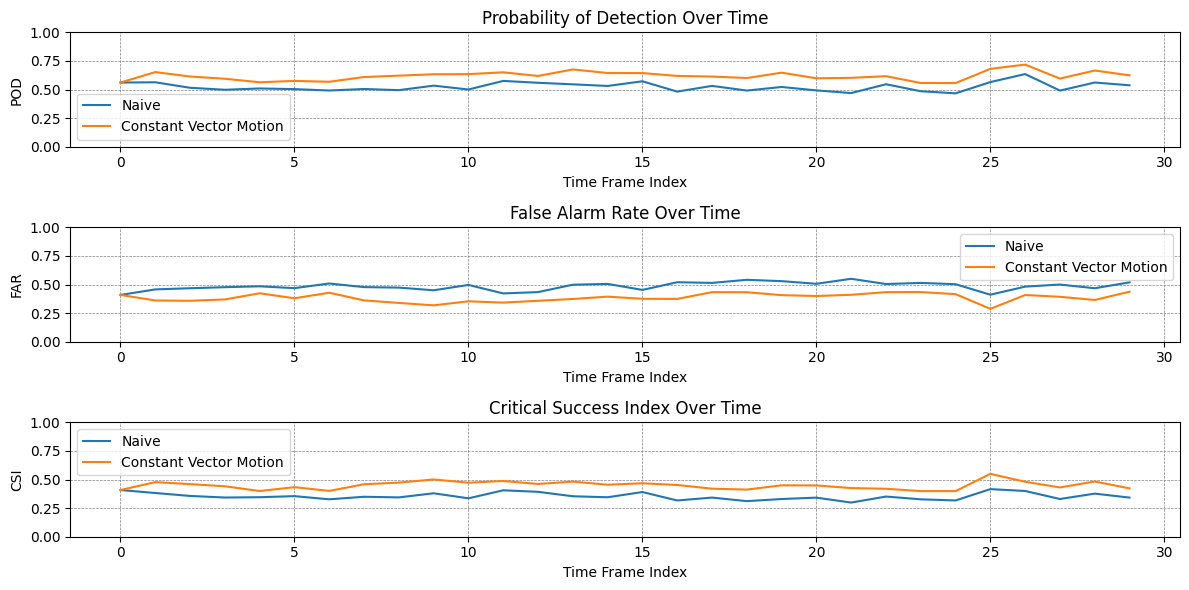

In [15]:
min_len = min(len(bm_pod_scores), len(pod_scores), len(far_scores), len(csi_scores))
indexes = range(min_len)

scores = [
    (bm_pod_scores[:min_len], pod_scores[:min_len]), 
    (bm_far_scores[:min_len], far_scores[:min_len]),
    (bm_csi_scores[:min_len], csi_scores[:min_len])
]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']
ylabels = ['POD', 'FAR', 'CSI']

plt.figure(figsize=(12, 6))

for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.plot(indexes, scores[i][0], label='Naive')
    plt.plot(indexes, scores[i][1], label='Constant Vector Motion')
    plt.title(title)
    plt.xlabel('Time Frame Index')
    plt.ylabel(ylabels[i])
    plt.ylim(0, 1)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()

plt.tight_layout()
plt.show()

### Store output

In [16]:
# import pandas as pd
# import os

# time_frame_list = [storms_map.time_frame for storms_map in storms_map_time_lst[:-1]]

# output_dir = f'output/{data_name}'
# os.makedirs(output_dir, exist_ok=True)

# df = pd.DataFrame({
#     'time': time_frame_list,
#     'POD': pod_scores,
#     'POD_Naive': bm_pod_scores,
#     'FAR': far_scores,
#     'FAR_Naive': bm_far_scores,
#     'CSI': csi_scores,
#     'CSI_Naive': bm_csi_scores,
# })

# df.to_csv(f'{output_dir}/STITAN.csv', index=False)

## 4. Evaluation

In [17]:
train_idx = 20
test_idx = 22

prev_storms_map = storms_map_time_lst[train_idx-1]
curr_storms_map = storms_map_time_lst[test_idx]

dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600.0
print(f"Overhead time: {dt * 60:.2f} minutes")

tracker = Tracker(max_velocity=MAX_VELOCITY)
tracker.fit(storms_map_time_lst[:train_idx], test=False, overlap_threshold=OVERLAP_THRESHOLD, block_size=BLOCK_SIZE)

pred_storms_map = DbzStormsMap([
        tracker.tracker.forecast(storm.id, dt)
        for storm in prev_storms_map.storms
    ], time_frame=curr_storms_map.time_frame, dbz_map=curr_storms_map.dbz_map)

print(f"POD score: {pod_score(pred_storms_map, curr_storms_map):.4f}")
print(f"CSI score: {csi_score(pred_storms_map, curr_storms_map):.4f}")
print(f"FAR score: {far_score(pred_storms_map, curr_storms_map):.4f}")

Overhead time: 17.15 minutes
POD score: 0.3116
CSI score: 0.1671
FAR score: 0.7356


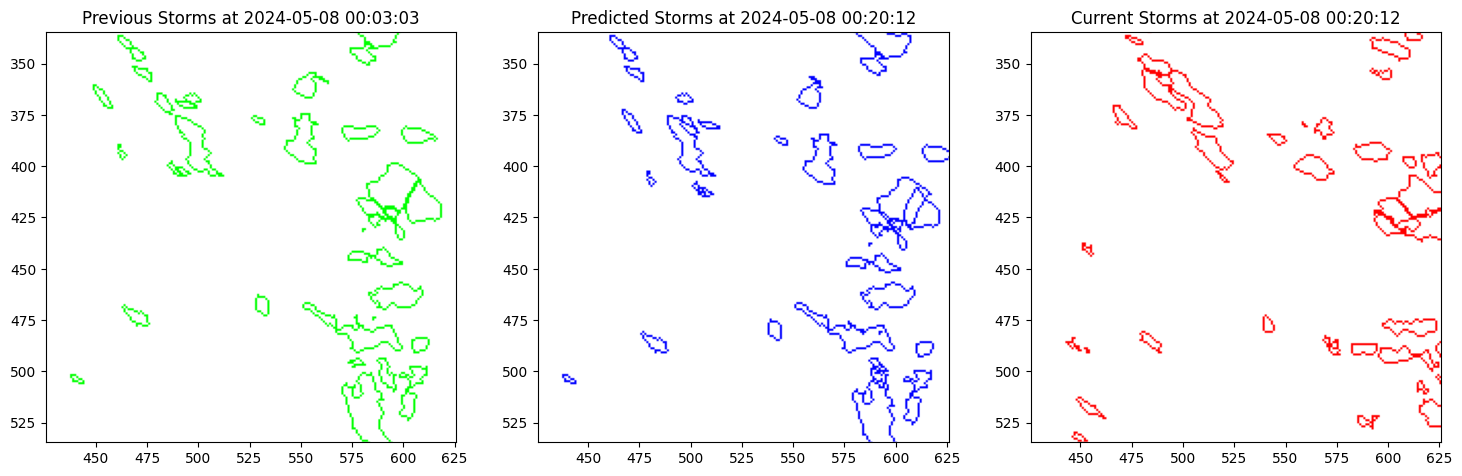

In [18]:
# get centroid storms for visualization
centroid_x_list = []
centroid_y_list = []
for storm in pred_storms_map.storms:
    centroid = storm.centroid
    centroid_x_list.append(centroid[1])
    centroid_y_list.append(centroid[0])

centroid_x = np.mean(centroid_x_list)
centroid_y = np.mean(centroid_y_list)

xlim_min, xlim_max = (centroid_x - 100, centroid_x + 100)
ylim_min, ylim_max = (centroid_y - 100, centroid_y + 100)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)

prev_contours = convert_polygons_to_contours([storm.contour for storm in prev_storms_map.storms])
blank_image = np.ones(img_shape, dtype=np.uint8) * 255
cv2.drawContours(blank_image, prev_contours, -1, (0, 255, 0), 1)
plt.title(f"Previous Storms at {prev_storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')}")
plt.imshow(blank_image)
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_max, ylim_min)

plt.subplot(1, 3, 2)

blank_image = np.ones(img_shape, dtype=np.uint8) * 255
pred_contours = convert_polygons_to_contours([storm.contour for storm in pred_storms_map.storms])
cv2.drawContours(blank_image, pred_contours, -1, (0, 0, 255), 1)
plt.title(f"Predicted Storms at {pred_storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')}")
plt.imshow(blank_image)
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_max, ylim_min)

plt.subplot(1, 3, 3)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255
curr_contours = convert_polygons_to_contours([storm.contour for storm in curr_storms_map.storms])
cv2.drawContours(blank_image, curr_contours, -1, (255, 0, 0), 1)
plt.title(f"Current Storms at {curr_storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')}")
plt.imshow(blank_image)
plt.xlim(xlim_min, xlim_max)
plt.ylim(ylim_max, ylim_min)

plt.show()

In [19]:
import pandas as pd

def forecast_evaluation(lead_time: int, train_len: int = 10):
    pod_scores = []
    csi_scores = []
    far_scores = []
    leading_times = []

    time_list = range(train_len, len(storms_map_time_lst)-lead_time)

    for train_idx in tqdm(time_list, total=len(time_list)):
        test_idx = train_idx + lead_time

        prev_storms_map = storms_map_time_lst[train_idx-1]
        curr_storms_map = storms_map_time_lst[test_idx]

        dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600.0

        tracker = Tracker(max_velocity=MAX_VELOCITY)
        tracker.fit(storms_map_time_lst[train_idx-train_len:train_idx], test=False, overlap_threshold=OVERLAP_THRESHOLD, block_size=BLOCK_SIZE)
        pred_storms_map = DbzStormsMap([
                tracker.tracker.forecast(storm.id, dt)
                for storm in prev_storms_map.storms
            ], time_frame=curr_storms_map.time_frame, dbz_map=curr_storms_map.dbz_map)

        pod_scores.append(pod_score(pred_storms_map, curr_storms_map))
        csi_scores.append(csi_score(pred_storms_map, curr_storms_map))
        far_scores.append(far_score(pred_storms_map, curr_storms_map))
        leading_times.append(dt * 60)  # convert to minutes

    forecast_lead_df = pd.DataFrame({
        'time': [storms_map_time_lst[i+lead_time].time_frame for i in time_list],
        'POD': pod_scores,
        'FAR': far_scores,
        'CSI': csi_scores,
        'leading_time (min)': leading_times
    })

    output_dir = f'output/{data_name}/{lead_time}_frame_leads'
    os.makedirs(output_dir, exist_ok=True)

    forecast_lead_df.to_csv(f'{output_dir}/STITAN.csv', index=False)
    print(f"Store file successfully at {output_dir}/STITAN.csv")

### 4.1 3-frame leads

In [20]:
df = forecast_evaluation(lead_time=3, train_len=10)
df

  0%|          | 0/18 [00:00<?, ?it/s]

Store file successfully at output/KGRR/3_frame_leads/STITAN.csv


### 4.2 5-frame leads

In [21]:
df = forecast_evaluation(lead_time=5, train_len=10)
df

  0%|          | 0/16 [00:00<?, ?it/s]

Store file successfully at output/KGRR/5_frame_leads/STITAN.csv
